In [1]:
cd '/home/kp266158/Downloads/Pooja/fastmri-reproducible-benchmark'

/home/kp266158/Downloads/Pooja/fastmri-reproducible-benchmark


In [2]:
# import os
# os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"  
# os.environ["CUDA_VISIBLE_DEVICES"]="6,7"

# # CUDA_VISIBLE_DEVICES=6,7
%env CUDA_DEVICE_ORDER=PCI_BUS_ID
%env CUDA_VISIBLE_DEVICES=4

env: CUDA_DEVICE_ORDER=PCI_BUS_ID
env: CUDA_VISIBLE_DEVICES=4


In [3]:
import os
os.environ['TF_FORCE_GPU_ALLOW_GROWTH'] = 'true'

In [4]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 13730153845734796413
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 47596913408
locality {
  bus_id: 1
  links {
  }
}
incarnation: 14814128873385529015
physical_device_desc: "device: 0, name: Quadro RTX 8000, pci bus id: 0000:21:00.0, compute capability: 7.5"
]


In [5]:
import os.path as op
import random
import time

import tensorflow as tf
from tensorflow.keras.callbacks import TensorBoard, ModelCheckpoint, ReduceLROnPlateau
from tensorflow_addons.callbacks import TQDMProgressBar

from fastmri_recon.data.sequences.senior_mc_sequences import Masked_MC_2DSequence
from fastmri_recon.models.functional_models.mcpdnet import mcpdnet

In [6]:
random.seed(0)

import glob
# paths
train_path = '/neurospin/optimed/SeniorData/Multicontrast_trainval'

# generators
AF = 4
train_gen = Masked_MC_2DSequence(
    train_path,
    af=AF,
    inner_slices=32,
    scale_factor=1e-2,
    seed=0,
    rand=True,
    val_split=0.2,
)
val_gen = train_gen.val_sequence
n_train = 46
n_val = 11

train_gen.filenames = random.sample(train_gen.filenames, n_train)
val_gen.filenames = random.sample(val_gen.filenames, n_val)


In [7]:
[kspace, mask], images = val_gen[0]

/home/kp266158/Downloads/Pooja/fastmri-reproducible-benchmark/fastmri_recon/data/sequences/senior_mc_sequences.py:143: ComplexWarning: Casting complex values to real discards the imaginary part
  images_scaled = images_scaled.astype(np.float32)


In [9]:
kspace.shape

(32, 3, 256, 256, 1)

In [12]:
mask.shape

(32, 3, 256, 256)

(-0.5, 255.5, 255.5, -0.5)

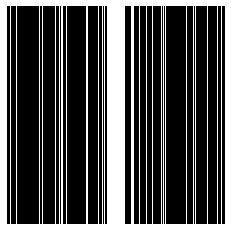

In [13]:
import matplotlib.pyplot as plt
plt.figure()
plt.imshow(mask[0][0], cmap='gray',  interpolation='none')
plt.axis('off')

In [14]:
from datetime import datetime

run_params = {
    'n_primal': 5,
    'n_dual': 5,
    'n_iter': 12,
    'n_filters': 32,
}

a = "{:%Y_%m_%d_%H_%M_%S}".format(datetime.now())
n_epochs = 100
run_id = f'mcpdnet_af{AF}_senior_{a}'
chkpt_path = f'checkpoints_senior/{run_id}' + '-{epoch:02d}.hdf5'
print(run_id)

mcpdnet_af4_senior_2021_09_09_11_29_16


In [15]:
chkpt_cback = ModelCheckpoint(chkpt_path, period=20, save_weights_only=True)
log_dir = op.join('logs', run_id)
tboard_cback = TensorBoard(
    profile_batch=0,
    log_dir=log_dir,
    histogram_freq=0,
    write_graph=True,
    write_images=False,
)
tqdm_cb = TQDMProgressBar()
lr_schedule = ReduceLROnPlateau(monitor='val_keras_psnr', factor=0.5, verbose=1, patience=15, mode='max'), 

## new_lr = lr * factor

model = mcpdnet(input_size=(None, None, None, 1), fastmri=False, lr=1e-3, **run_params)

print(model.summary(line_length=150))

Model: "model"
______________________________________________________________________________________________________________________________________________________
Layer (type)                                     Output Shape                     Param #           Connected to                                      
kspace_input (InputLayer)                        [(None, None, None, None, 1)]    0                                                                   
______________________________________________________________________________________________________________________________________________________
buffer_primal (Lambda)                           (None, None, None, None, 5)      0                 kspace_input[0][0]                                
______________________________________________________________________________________________________________________________________________________
mask_input (InputLayer)                          [(None, None, None, None)]    

In [16]:
history = model.fit(
    train_gen,
    steps_per_epoch=n_train,
    epochs=n_epochs,
    validation_data=val_gen,
    validation_steps=1,
    verbose=0,
    callbacks=[tqdm_cb, lr_schedule, tboard_cback, chkpt_cback,],
    # max_queue_size=35,
    use_multiprocessing=True,
    workers=35,
    shuffle=False,
)

/home/kp266158/Downloads/Pooja/fastmri-reproducible-benchmark/fastmri_recon/data/sequences/senior_mc_sequences.py:143: ComplexWarning: Casting complex values to real discards the imaginary part
  images_scaled = images_scaled.astype(np.float32)


Epoch 1/100



Epoch 2/100



Epoch 3/100



Epoch 4/100



Epoch 5/100



Epoch 6/100



Epoch 7/100



Epoch 8/100



Epoch 9/100



Epoch 10/100



Epoch 11/100



Epoch 12/100



Epoch 13/100



Epoch 14/100



Epoch 15/100



Epoch 16/100



Epoch 17/100



Epoch 18/100



Epoch 19/100



Epoch 20/100



Epoch 21/100



Epoch 22/100



Epoch 23/100



Epoch 24/100



Epoch 25/100



Epoch 26/100



Epoch 27/100



Epoch 28/100



Epoch 29/100



Epoch 30/100



Epoch 31/100



Epoch 32/100



Epoch 33/100



Epoch 34/100



Epoch 35/100



Epoch 36/100



Epoch 37/100



Epoch 38/100



Epoch 39/100



Epoch 40/100



Epoch 41/100



Epoch 42/100



Epoch 43/100



Epoch 44/100



Epoch 45/100



Epoch 46/100



Epoch 47/100



Epoch 48/100



Epoch 49/100



Epoch 50/100



Epoch 51/100



Epoch 52/100



Epoch 53/100



Epoch 54/100



Epoch 55/100



Epoch 56/100



Epoch 57/100



Epoch 58/100



Epoch 59/100



Epoch 60/100



Epoch 61/100



Epoch 62/100



Epoch 63/100



Epoch 64/100



Epoch 65/100



Epoch 66/100



Epoch 67/100




Epoch 00067: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
Epoch 68/100



Epoch 69/100



Epoch 70/100



Epoch 71/100



Epoch 72/100



Epoch 73/100



Epoch 74/100



Epoch 75/100



Epoch 76/100



Epoch 77/100



Epoch 78/100



Epoch 79/100



Epoch 80/100



Epoch 81/100



Epoch 82/100



Epoch 83/100



Epoch 84/100



Epoch 85/100



Epoch 86/100



Epoch 87/100



Epoch 88/100



Epoch 89/100



Epoch 90/100



Epoch 91/100



Epoch 92/100



Epoch 93/100



Epoch 94/100



Epoch 95/100



Epoch 96/100



Epoch 97/100



Epoch 98/100



Epoch 99/100



Epoch 100/100


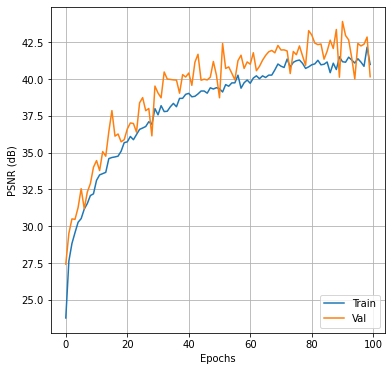

In [17]:
# Plot training & validation PSNR values
import matplotlib.pyplot as plt
plt.figure()
fig = plt.gcf()
fig.set_size_inches(6, 6)
plt.plot(history.history['keras_psnr'])
plt.plot(history.history['val_keras_psnr'])
plt.ylabel('PSNR (dB)')
plt.xlabel('Epochs')
plt.grid()
plt.legend(['Train', 'Val'], loc='lower right')
plt.show()

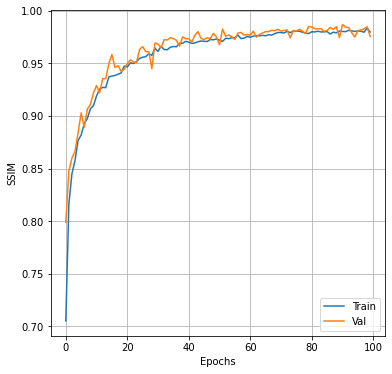

In [18]:
plt.figure()
fig = plt.gcf()
fig.set_size_inches(6, 6)
plt.plot(history.history['keras_ssim'])
plt.plot(history.history['val_keras_ssim'])
#plt.title('Model Dice Metric')
plt.ylabel('SSIM')
plt.xlabel('Epochs')
plt.grid()
plt.legend(['Train', 'Val'], loc='lower right')
plt.show()

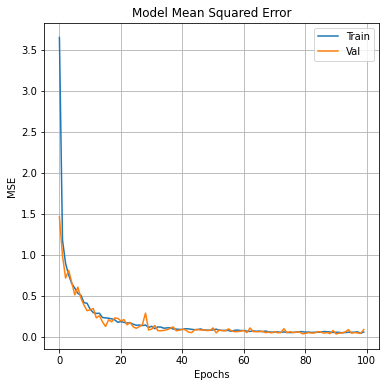

In [19]:

# Plot training & validation loss values
plt.figure()
fig = plt.gcf()
fig.set_size_inches(6, 6)
plt.plot(history.history['mean_squared_error'])
plt.plot(history.history['val_mean_squared_error'])
plt.title('Model Mean Squared Error')
plt.ylabel('MSE')
plt.xlabel('Epochs')
plt.grid()
plt.legend(['Train', 'Val'], loc='upper right')
plt.show()

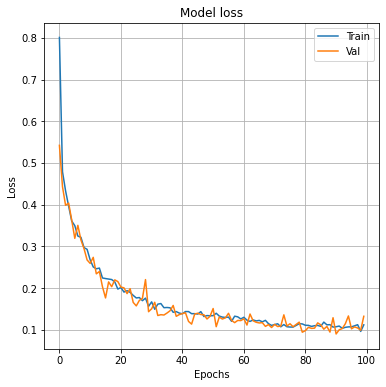

In [20]:
plt.figure()
fig = plt.gcf()
fig.set_size_inches(6, 6)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.grid()
plt.legend(['Train', 'Val'], loc='upper right')
plt.show()